In [11]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [12]:
%cd D:/archive/food-101

D:\archive\food-101


In [13]:
# Helper function to download data and extract
def get_data_extract():
    if "food-101" in os.listdir():
        print("Dataset already exists")
    else:
        print("Downloading the data...")
        !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
        print("Dataset downloaded!")
        print("Extracting data..")
        !tar xzvf food-101.tar.gz
        print("Extraction done!")

In [14]:
# Download data and extract it to folder
get_data_extract()

Dataset already exists


In [15]:
# Check the extracted dataset folder
!ls food-101/

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [16]:
os.listdir('food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

## Visualize random image

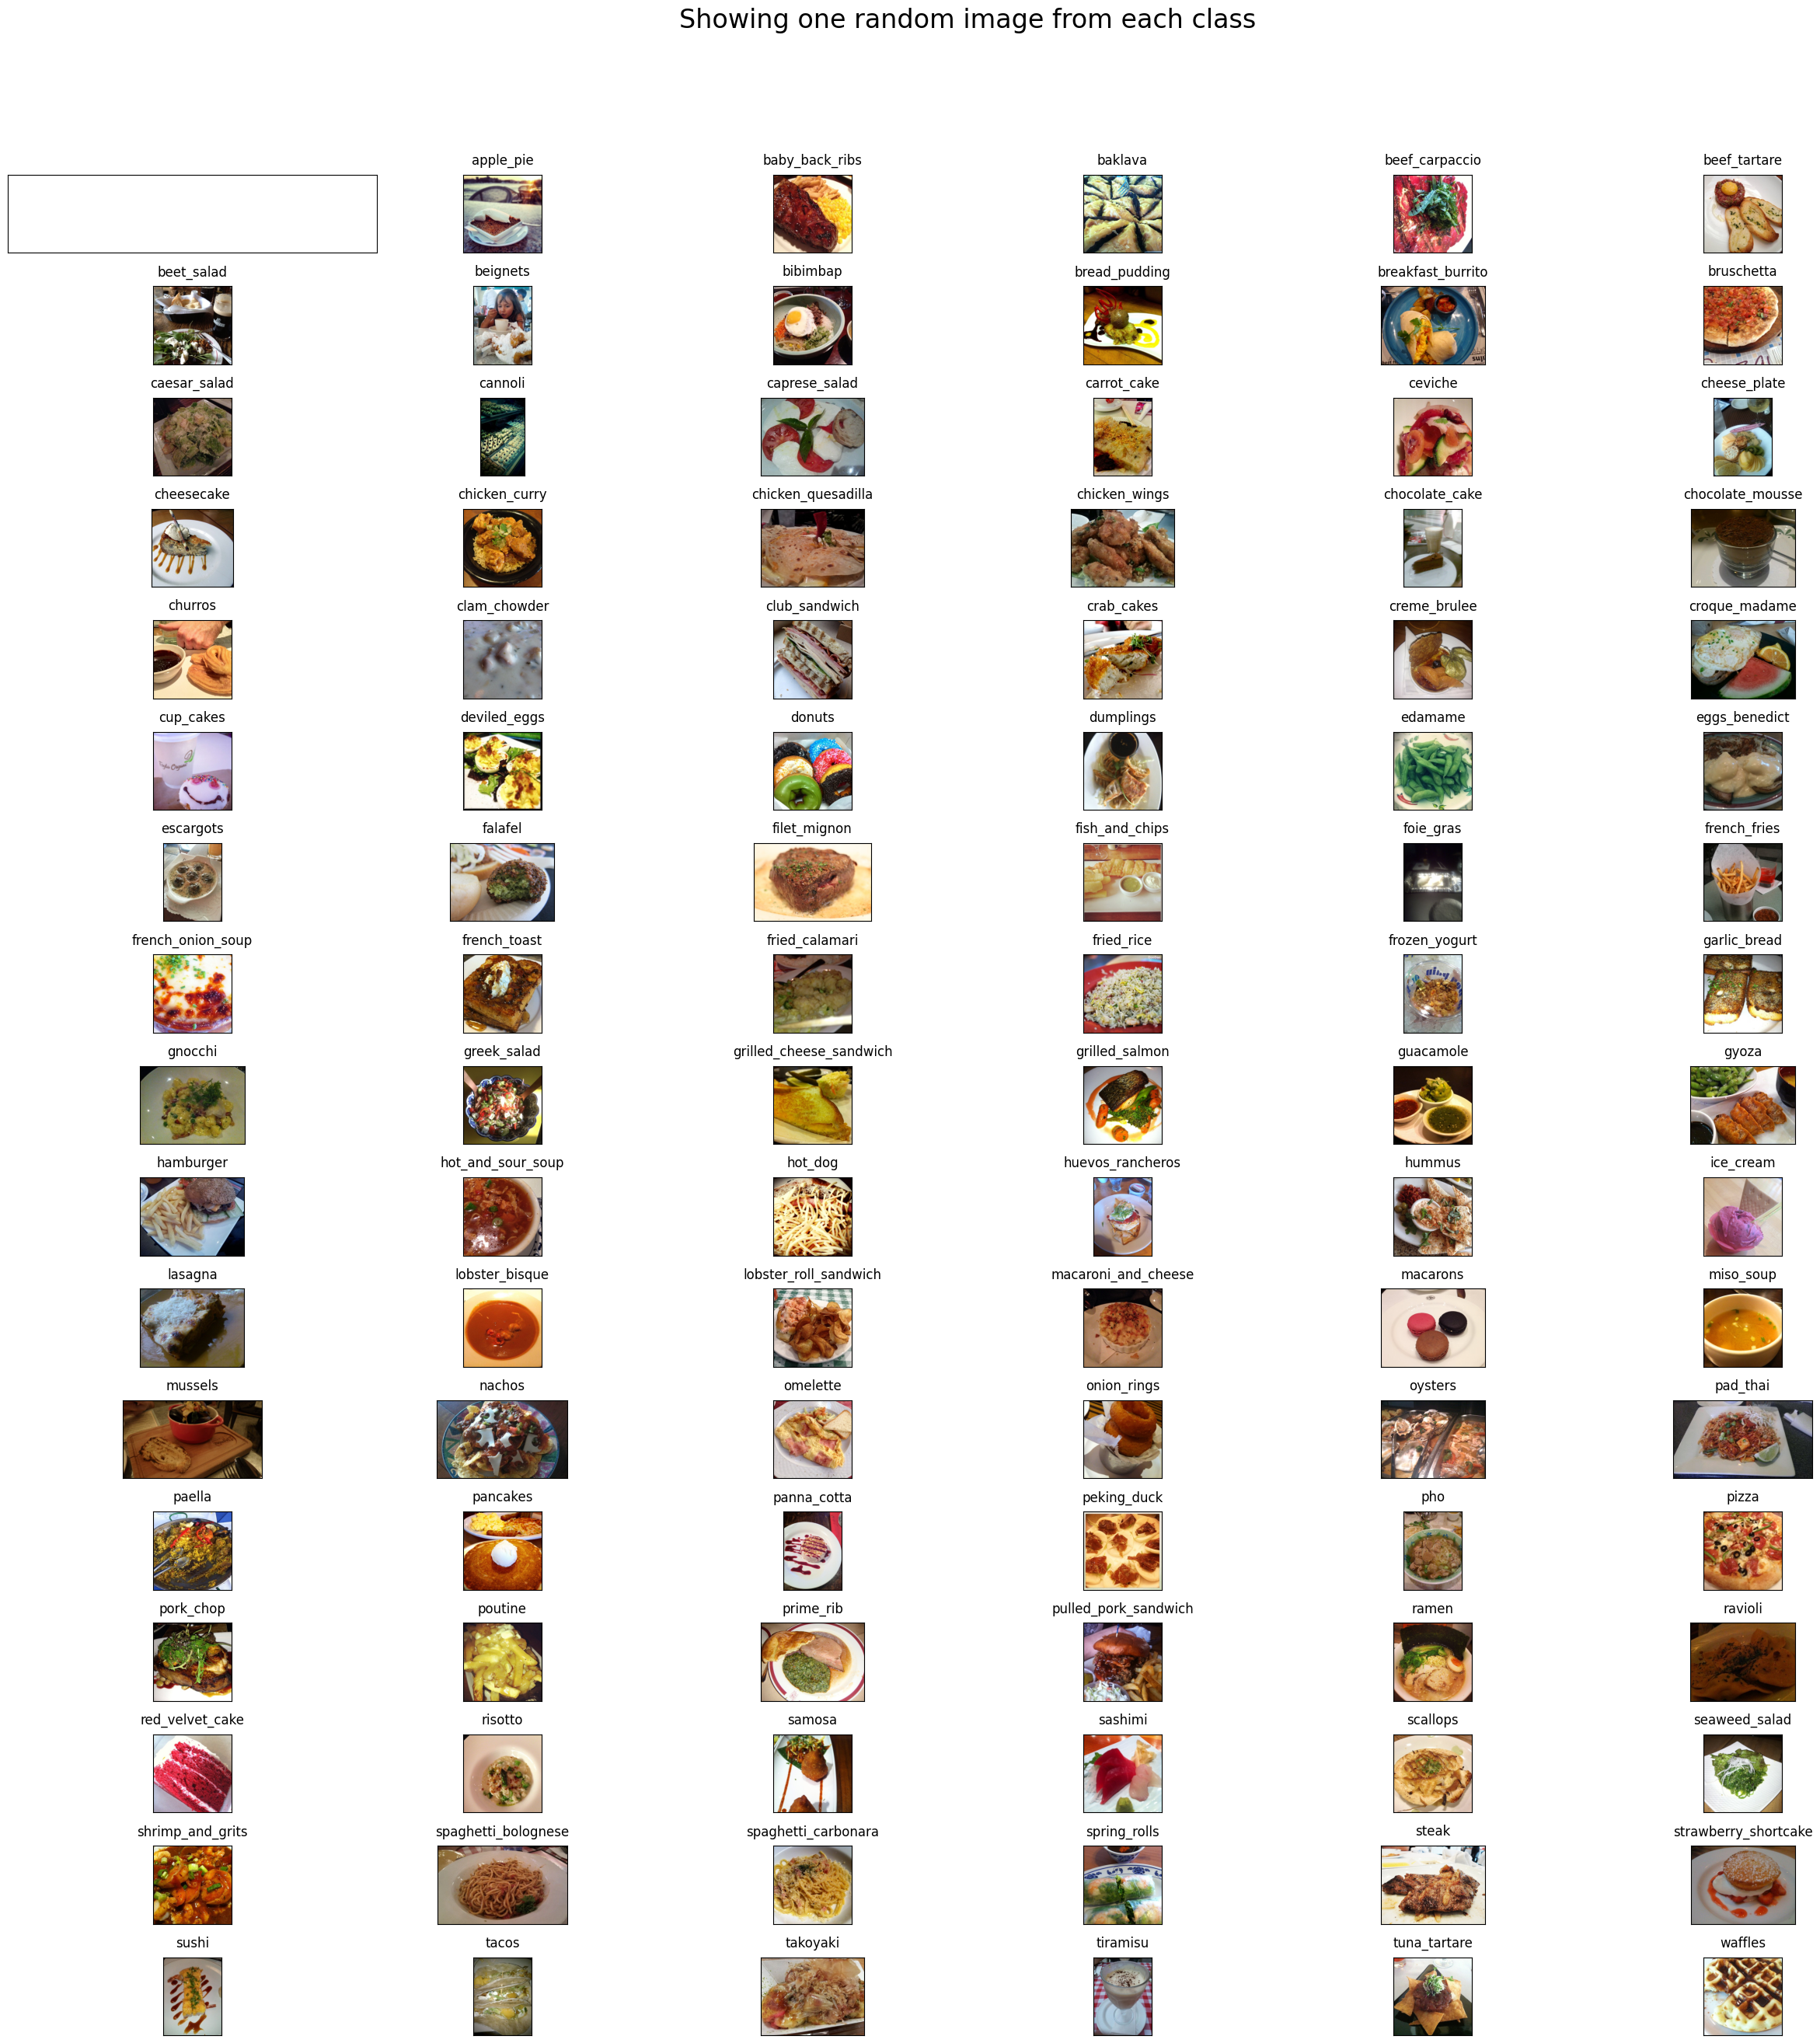

In [18]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id] 
            food_id += 1
        except:
            break
        if food_selected == '.DS_Store':
            continue
        food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
        food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
        img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

## Split the data

In [20]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [22]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('D:/archive/food-101/food-101/meta/train.txt', 'D:/archive/food-101/food-101/images', 'train')

D:\
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copyin

In [46]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('D:/archive/food-101/food-101/meta/test.txt', 'D:/archive/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [47]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder


'wc'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [48]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder


'wc'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [49]:
os.chdir('/')

## Create a subset of data with few classes

In [50]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [51]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [52]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
    if os.path.exists(dest):
        rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
    os.makedirs(dest)
    for food_item in food_list :
        print("Copying images into",food_item)
        copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [53]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'D:/archive/food-101/working/train_mini'
src_test = 'test'
dest_test = 'D:/archive/food-101/working/test_mini'

In [54]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes


Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [55]:
print("Total number of samples in train folder")

!find D:/archive/food-101/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder


'wc'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


### Fine tune ResNet50 Pretrained model using Food 101 dataset

In [57]:
from tensorflow.keras.applications.resnet50 import ResNet50

K.clear_session()
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = 'D:/archive/food-101/working/train_mini'
validation_data_dir = 'D:/archive/food-101/working/test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='D:/archive/food-101/working/best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('D:/archive/food-101/working/history_3class.log')

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('D:/archive/food-101/working/model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 0 images belonging to 0 classes.
Epoch 1/30
140/140 [==============================] - 22s 138ms/step - loss: 1.0829 - accuracy: 0.4758
Epoch 2/30
140/140 [==============================] - 20s 143ms/step - loss: 0.7440 - accuracy: 0.7046
Epoch 3/30
140/140 [==============================] - 20s 142ms/step - loss: 0.5905 - accuracy: 0.7847
Epoch 4/30
140/140 [==============================] - 20s 139ms/step - loss: 0.5232 - accuracy: 0.8098
Epoch 5/30
140/140 [==============================] - 19s 138ms/step - loss: 0.4574 - accuracy: 0.8299
Epoch 6/30
140/140 [==============================] - 20s 139ms/step - loss: 0.4200 - accuracy: 0.8456
Epoch 7/30
140/140 [==============================] - 20s 139ms/step - loss: 0.3606 - accuracy: 0.8765
Epoch 8/30
140/140 [==============================] - 20s 141ms/step - loss: 0.3386 - accuracy: 0.8868
Epoch 9/30
140/140 [==============================] - 20s 142ms/step - loss: 0.3222 - accuracy:

In [58]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

### Visualize the accuracy and loss

In [59]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

KeyError: 'val_accuracy'

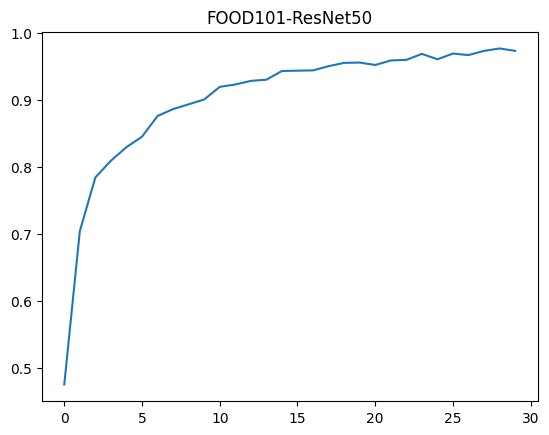

In [60]:
plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

### Predicting classes for the new imgs